In [1]:
import urllib.request
import requests
import pandas as pd
import seaborn as sns
import geopandas as gpd
import json
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from shapely.geometry import MultiPolygon, Polygon, Point, MultiPoint, LineString
from shapely.ops import split
from pyproj import Geod

## Fail of the day
In the previous notebooks, I chose the transformation [epsg:5756](https://epsg.io/5756) because it looks to me to be a coordinate system that handle martinique with meters (and not degrees).
What I misread (thanks for rushing) is that the espe 5756 is for vertical mesurements

Therefore the right coordinate system seems to be the [2973](https://epsg.io/2973)
I will update the other notebook later.

## Idea
Ukraine flag is composed of two colours: blue and yellow. In Martinique, there the sea and some sand/land.  
Let's calculate how much each coastal city's perimeter touch the sea vs the land. Then use that proportion to fill each city area with the ukraine colours and create a map of flags.

Inland cities are ignored.

In [2]:
COMMUNES_FILE = 'data/communes-martinique.geojson'

In [3]:
UKR_SEA_COLOR = "#0057b7"
UKR_SAND_COLOR = "#ffd700"

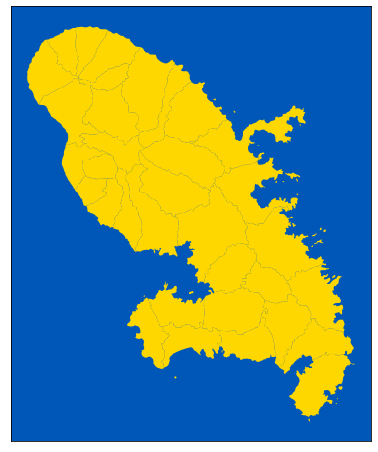

In [4]:
gdf_mq = gpd.read_file(COMMUNES_FILE)
gdf_mq.code = gdf_mq.code.astype(int)
initial_crs = gdf_mq.geometry.crs.srs
# add the perimeter, mind the multipolygons
gdf_mq = gdf_mq.join(gdf_mq.explode(index_parts=True).to_crs('epsg:2973').exterior.length.droplevel(1).reset_index().groupby(by='index').agg(perimeter=(0, 'sum')))
ax = gdf_mq.plot(color=UKR_SAND_COLOR, figsize=(8,8))
ax.set_facecolor(UKR_SEA_COLOR)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

<AxesSubplot:>

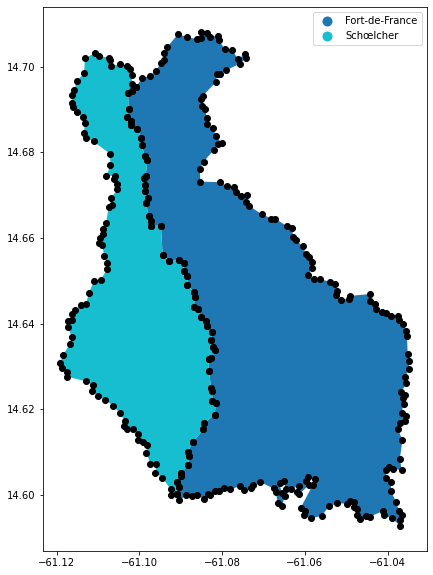

In [5]:
# schoelcher & fort de france share some boundaries, let's see if it makes sense
s = gdf_mq.loc[gdf_mq.code.isin([97229, 97209])] 
ax = s.plot(column='nom', legend=True, figsize=(10,10))

pts = s.copy()
pts.geometry = pts.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))
pts = pts.explode(index_parts=True)

pts.plot(ax=ax, color='black')

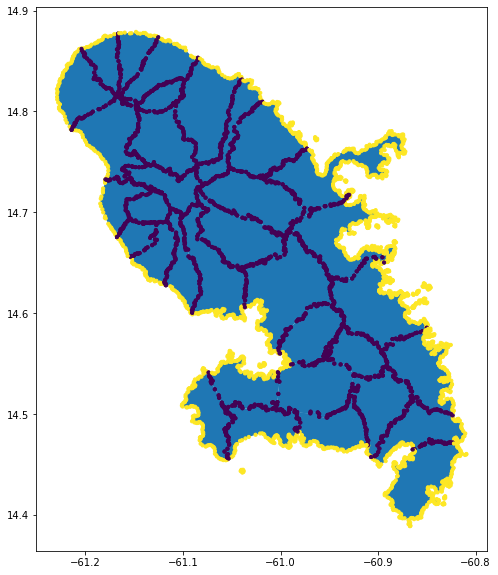

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_mq.plot(ax=ax)

pts = gdf_mq.explode(index_parts=True)
pts.geometry = pts.geometry.apply(lambda x: MultiPoint(list(x.exterior.coords)))
pts = pts.explode(index_parts=True)

all_sea_points = []
for code in pts.code.unique():
    current_points = pts.loc[pts.code == code].to_crs('epsg:2973')
    other_boundaries = gdf_mq.loc[gdf_mq.code != code].to_crs('epsg:2973').explode(index_parts=True)
    
    current_points['is_sea'] = current_points['geometry'].apply(lambda x: other_boundaries.distance(x).min() > 10)
    current_points.to_crs(initial_crs).plot(column='is_sea', ax=ax, markersize=10)

    all_sea_points.append(current_points.loc[current_points.is_sea])

In [7]:
sea_points = pd.concat(all_sea_points).reset_index()
sea_points['next'] = sea_points['geometry'].shift(-1)
sea_points['next_id'] = sea_points['level_2'].shift(-1)
sea_points['d'] = np.where(sea_points['next_id'] == sea_points['level_2'] + 1, sea_points['geometry'].distance(sea_points['next']), 0)
sea_perimeter = sea_points.groupby('code').agg(sea_perimeter=('d', 'sum')).reset_index()
gdf_mq = gdf_mq.merge(sea_perimeter, on='code', how='left').fillna(0)
gdf_mq['sea_ratio'] = gdf_mq['sea_perimeter'] / gdf_mq['perimeter']
gdf_mq.head()

,code,nom,geometry,perimeter,sea_perimeter,sea_ratio
0,97201,Ajoupa-Bouillon,"POLYGON ((-61.14848 14.80590, -61.15340 14.805...",20244.547490,0.000000,0.000000
1,97202,Anses-d'Arlet,"MULTIPOLYGON (((-61.05330 14.45579, -61.05472 ...",32418.504362,18637.998542,0.574919
2,97203,Basse-Pointe,"POLYGON ((-61.16381 14.81601, -61.16249 14.818...",25641.902549,4773.534355,0.186161
3,97204,Carbet,"POLYGON ((-61.16765 14.67530, -61.16847 14.676...",24720.977371,6594.763438,0.266768
4,97205,Case-Pilote,"POLYGON ((-61.11754 14.62759, -61.11877 14.628...",22589.892797,6065.643905,0.268511
5,97206,Diamant,"MULTIPOLYGON (((-61.05793 14.50678, -61.05356 ...",39758.179980,14589.143146,0.366947
6,97207,Ducos,"POLYGON ((-61.00063 14.55991, -61.00108 14.560...",28998.217727,2194.184461,0.075666
7,97208,Fonds-Saint-Denis,"POLYGON ((-61.12165 14.71927, -61.12344 14.719...",30202.343571,0.000000,0.000000
8,97209,Fort-de-France,"POLYGON ((-61.10080 14.69536, -61.09925 14.697...",45239.771413,11853.346933,0.262012
9,97210,François,"MULTIPOLYGON (((-60.93572 14.58822, -60.93520 ...",62266.401537,33171.134594,0.532729


In [19]:
all_data = []
geod = Geod(ellps="WGS84")
for i in range(34):
    city = gdf_mq.loc[i]['geometry']
    
    target_ratio = gdf_mq.loc[i]['sea_ratio']
    bounds = city.bounds

    p1 = Point(bounds[0],bounds[-1])
    p2 = Point(bounds[0],bounds[1])
    p3 = Point(bounds[-2],bounds[1])
    p4 = Point(bounds[-2],bounds[-1])
    point_list = [p1, p2, p3, p4, p1]
    bounds_poly = Polygon(point_list)

    base_h = bounds[3]
    height = bounds[1] - bounds[3]

    ratio_min = (0, 0)
    ratio_max = (1, 1)
    epsilon = 0.005
    # lets try to find iteratively a proportion very close to the target, up to a very small difference.
    for i in range(10):
        ratio = (ratio_min[0] + ratio_max[0]) / 2

        split_a = (bounds[0], base_h + height * ratio)
        split_b = (bounds[2], base_h + height * ratio)

        # here, you can also have more than 2 polygons, thanks captain obvious
        line = LineString([split_a, split_b])

        boundaries = split(bounds_poly, line)
        x = split(city, line)
        collection_of_polygons = x

        group1, group2 = [],[]
        for p in collection_of_polygons.geoms:
            if p.within(boundaries.geoms[0]):
                group1.append(p)
            else:
                group2.append(p)
        group_multi1 = MultiPolygon(group1)
        group_multi2 = MultiPolygon(group2)


        areas_a, areas_b = geod.geometry_area_perimeter(x.geoms[1]), geod.geometry_area_perimeter(x.geoms[0])

        area_ratio = areas_a[0] / (areas_a[0] + areas_b[0])
        if area_ratio < target_ratio * (1 - epsilon):
            ratio_min = (ratio, area_ratio)
        elif area_ratio > target_ratio * (1 + epsilon):
            ratio_max = (ratio, area_ratio)
        else:
            break

    if target_ratio == 0:
        all_data.append(gpd.GeoDataFrame(data={"code": i, "geometry":group_multi2, "t": "white"})) # white makes the output even worst !
    else:
        all_data += [
            gpd.GeoDataFrame(data={"code": i, "geometry":group_multi1, "t": UKR_SEA_COLOR}),
            gpd.GeoDataFrame(data={"code": i, "geometry":group_multi2, "t": UKR_SAND_COLOR})
        ]

X = gpd.GeoDataFrame(pd.concat(all_data, ignore_index=True), crs=all_data[0].crs)
ukr_palette = {"SEA": UKR_SEA_COLOR, "SAND": UKR_SAND_COLOR}
cmap = matplotlib.colors.ListedColormap([UKR_SAND_COLOR, UKR_SEA_COLOR])

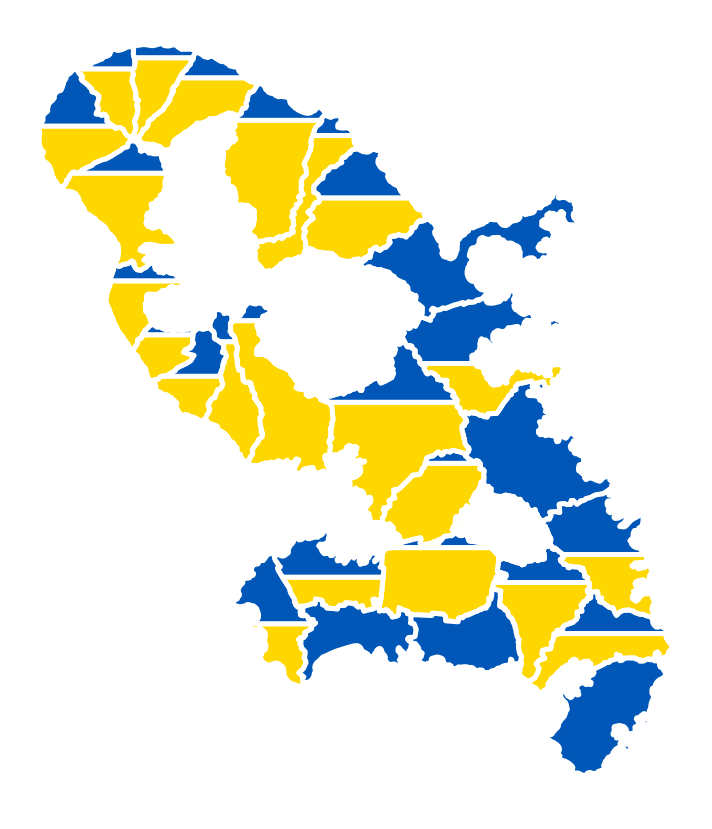

In [34]:
ax = X.plot(color=X["t"], legend=True, figsize=(15,15), linewidth=5, edgecolor='white')
ax.axis("off")
plt.savefig('output/2022-11-05.png')

In [27]:
print("fuck the Z")

fuck the Z
